In [1]:
import os, logging
import numpy as np
import torch as th
from Transformations import *
from BloodDataset import BloodDataset
from Data import get_datasets
from ExploratoryDataAnalysis import *

/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
np.random.seed(0)
th.manual_seed(0)
logger = logging.getLogger('MSP_Project')
logging.basicConfig(level=logging.DEBUG)
logger.setLevel(logging.DEBUG)

in_colab = False
if os.getenv("COLAB_RELEASE_TAG"):
    in_colab = True
    logger.debug("Running in Colab")
USING_MNIST = False

train_set, test_set = get_datasets(in_colab, USING_MNIST)

DEBUG:MSP_Project:Data directory: ./full_dataset
DEBUG:MSP_Project:Trying to get a representative test set...
DEBUG:MSP_Project:93 images in training set before augmentation.
DEBUG:MSP_Project:465 images in training set.
DEBUG:MSP_Project:23 images in test set.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

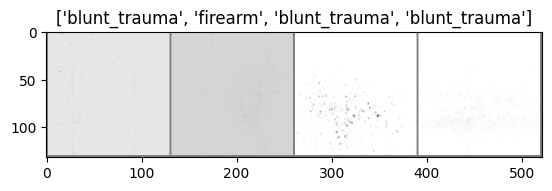

DEBUG:MSP_Project:Dataset classes:['blunt_trauma', 'firearm']
DEBUG:MSP_Project:Class Counts: [250, 215]


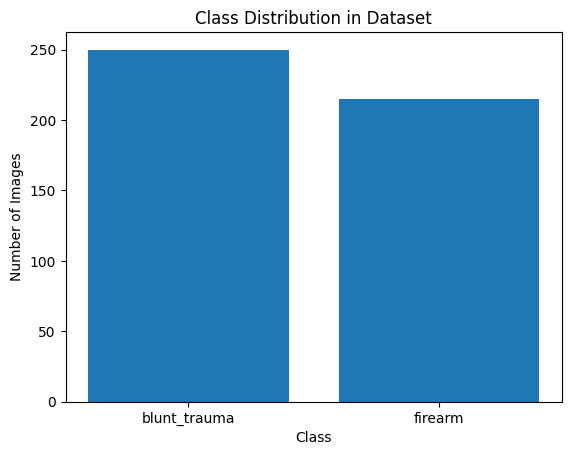

In [3]:
run_eda(train_set)

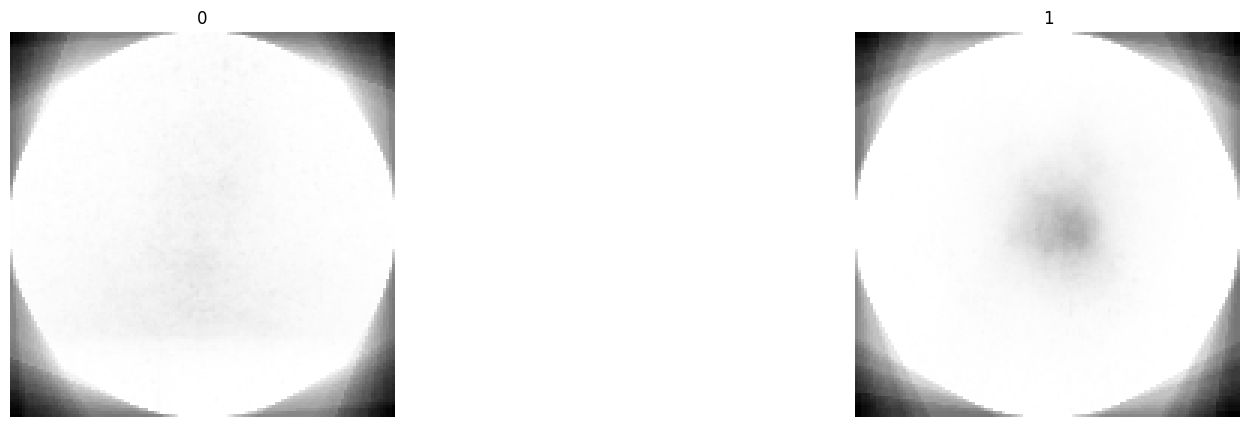

In [4]:
calculate_class_average(train_set)